Tabel disimpan ke: /Users/ferrinciaavril/Downloads/UTS_VISDAT/category_table_2021_2022.html


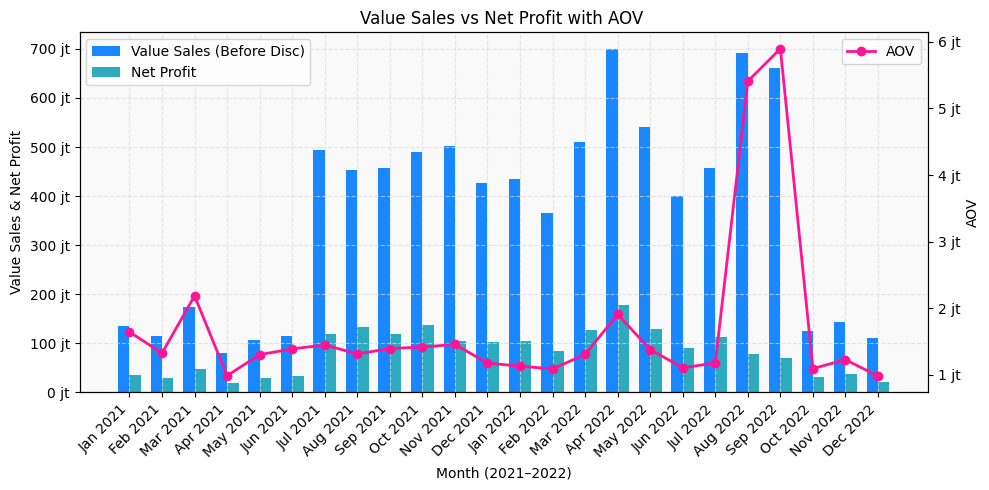


=== Dashboard Summary (KPIs) — 2021–2022 ===
 Total Value Sales 2021–2022  Total Revenue 2021–2022  Total Profit 2021–2022  Avg Margin % 2021–2022  Total Orders 2021–2022  Unique Customers 2021–2022   Date Min   Date Max
                  8693190857               8659356440              1973972297                   24.72                    5764                        3998 2021-01-07 2022-12-08


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# 1) LOADING DATA & PREP
file_path = "DATASET_UTS.csv"
df = pd.read_csv(file_path)

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['registered_date'] = pd.to_datetime(df.get('registered_date'), errors='coerce')

num_cols = ['price','qty_ordered','before_discount','discount_amount','after_discount','cogs']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

# Value Sales (Before Discount) & Revenue (After Discount)
df['value_sales'] = df['before_discount']
df['revenue'] = np.where(df['after_discount'] > 0,
                         df['after_discount'],
                         df['before_discount'] - df['discount_amount'])

# Net Profit (per baris) & Margin
df['profit'] = (df['price'] - df['cogs']) * df['qty_ordered'] - df['discount_amount']
df['margin_pct'] = np.where(df['revenue'] > 0, df['profit'] / df['revenue'] * 100, np.nan)

# 2) FILTER 2021–2022
df_2122 = df.loc[df['order_date'].dt.year.between(2021, 2022)].copy()

# 3) TABEL PER KATEGORI (2021–2022)
cat_2122 = (
    df_2122.groupby('category', dropna=False)
           .agg(value_sales=('value_sales', 'sum'),
                net_profit=('profit', 'sum'))
           .reset_index()
           .sort_values('value_sales', ascending=False)
)
cat_2122['pct_net_profit'] = np.where(
    cat_2122['value_sales'] > 0,
    cat_2122['net_profit'] / cat_2122['value_sales'] * 100,
    np.nan
)
cat_2122.insert(0, 'No.', np.arange(1, len(cat_2122)+1))

def fmt_idr0(x): return '{:,.0f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')
def fmt_pct2(x): return '{:,.2f}%'.format(x)

styler = (cat_2122.rename(columns={
                'category': 'Category',
                'value_sales': 'Value Sales',
                'net_profit': 'Net Profit',
                'pct_net_profit': '% Net Profit'})
          .style
          .format({'Value Sales': fmt_idr0, 'Net Profit': fmt_idr0, '% Net Profit': fmt_pct2})
          .background_gradient(subset=['Value Sales'], cmap='Blues')
          .background_gradient(subset=['Net Profit'],  cmap='GnBu')
          .background_gradient(subset=['% Net Profit'], cmap='PuRd')
)
styler 

outdir = Path(".")
out_html = outdir / "category_table_2021_2022.html"
with open(out_html, "w", encoding="utf-8") as f:
    f.write(styler.to_html())
print(f"Tabel disimpan ke: {out_html.resolve()}")

# 4) GRAFIK (Value Sales vs Net Profit + AOV)
monthly = (
    df_2122.dropna(subset=['order_date'])
           .assign(month=lambda d: d['order_date'].dt.to_period('M').dt.to_timestamp())
           .groupby('month', as_index=False)
           .agg(value_sales=('value_sales','sum'),
                profit=('profit','sum'),
                orders=('id','nunique'))
)
monthly['aov'] = np.where(monthly['orders'] > 0, monthly['value_sales'] / monthly['orders'], np.nan)

x = np.arange(len(monthly))
width = 0.35

def label_million(x, pos): return f"{int(x/1e6)} jt"

fig, ax1 = plt.subplots(figsize=(10,5))
bars1 = ax1.bar(x - width/2, monthly['value_sales'], width,
                label='Value Sales (Before Disc)', color="#007bff", alpha=0.9)
bars2 = ax1.bar(x + width/2, monthly['profit'],  width,
                label='Net Profit', color="#17a2b8", alpha=0.9)

ax2 = ax1.twinx()
ax2.plot(x, monthly['aov'], color="#ff1493", marker='o', linewidth=2, label='AOV')

ax1.set_title('Value Sales vs Net Profit with AOV ')
ax1.set_xlabel('Month (2021–2022)')
ax1.set_ylabel('Value Sales & Net Profit')
ax2.set_ylabel('AOV')

ax1.set_xticks(x)
ax1.set_xticklabels(monthly['month'].dt.strftime('%b %Y'), rotation=45, ha='right')

ax1.yaxis.set_major_formatter(FuncFormatter(label_million))
ax2.yaxis.set_major_formatter(FuncFormatter(label_million))

ax1.set_facecolor("#f9f9f9")
ax2.set_facecolor("#f9f9f9")
ax1.grid(True, color="#dcdcdc", linestyle="--", alpha=0.7)

ax1.legend(loc='upper left'); ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(outdir / "dualbar_value_net_aov_2021_2022.png", dpi=160)
plt.show()

# 5) KPI ringkas (2021–2022)
summary = pd.DataFrame({
    'Total Value Sales 2021–2022': [df_2122['value_sales'].sum()],
    'Total Revenue 2021–2022'    : [df_2122['revenue'].sum()],
    'Total Profit 2021–2022'     : [df_2122['profit'].sum()],
    'Avg Margin % 2021–2022'     : [df_2122.loc[df_2122['revenue']>0, 'margin_pct'].mean()],
    'Total Orders 2021–2022'     : [df_2122['id'].nunique()],
    'Unique Customers 2021–2022' : [df_2122['customer_id'].nunique()],
    'Date Min'                   : [df_2122['order_date'].min()],
    'Date Max'                   : [df_2122['order_date'].max()]
})
print("\n=== Dashboard Summary (KPIs) — 2021–2022 ===")
print(summary.round(2).to_string(index=False))




In [8]:
from IPython.display import display
display(styler)

,No.,Category,Value Sales,Net Profit,% Net Profit
9,1,Mobiles & Tablets,3.456.994.648,646.873.658,18.71%
4,2,Entertainment,1.333.826.829,323.943.684,24.29%
3,3,Computing,1.198.593.664,340.020.494,28.37%
0,4,Appliances,1.189.879.249,297.214.827,24.98%
8,5,Men Fashion,282.314.536,67.245.547,23.82%
14,6,Women Fashion,268.592.391,64.544.865,24.03%
6,7,Home & Living,213.384.436,57.411.209,26.91%
1,8,Beauty & Grooming,170.571.968,45.038.402,26.40%
10,9,Others,152.678.098,30.083.277,19.70%
5,10,Health & Sports,150.850.518,35.521.893,23.55%


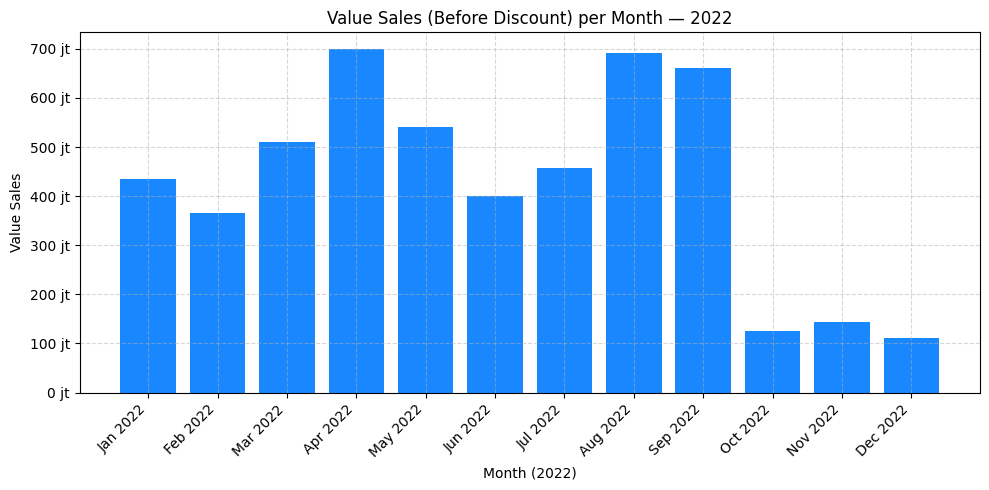

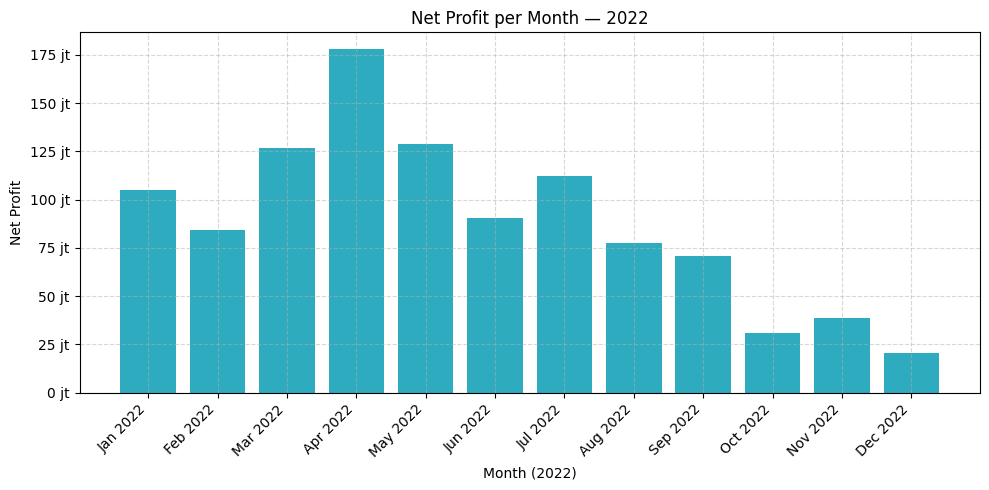

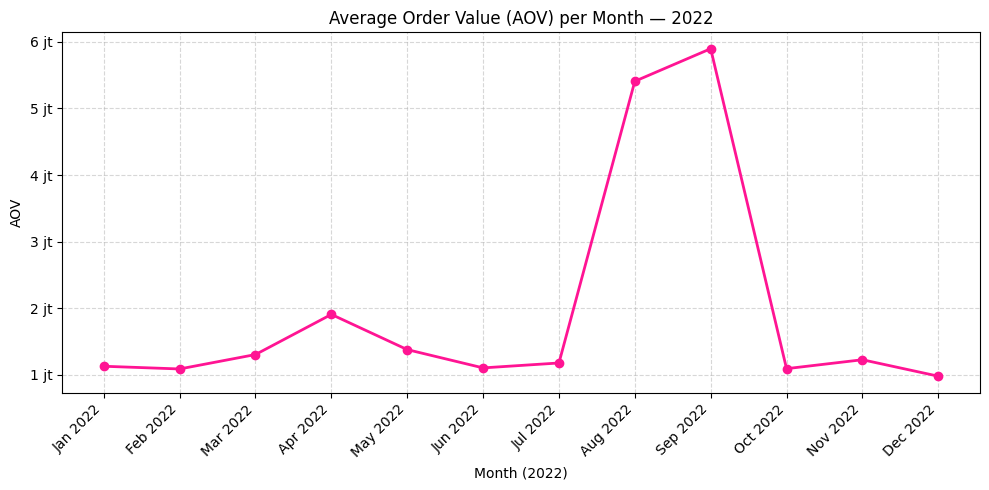

In [ ]:
from matplotlib.ticker import FuncFormatter

df_2022 = df.loc[df['order_date'].dt.year == 2022].copy()

monthly_2022 = (
        df_2022.dropna(subset=['order_date'])
                   .assign(month=lambda d: d['order_date'].dt.to_period('M').dt.to_timestamp())
                   .groupby('month', as_index=False)
                   .agg(value_sales=('value_sales','sum'),
                                profit=('profit','sum'),
                                orders=('id','nunique'))
)
monthly_2022['AOV'] = np.where(monthly_2022['orders'] > 0,
                                                           monthly_2022['value_sales'] / monthly_2022['orders'],
                                                           np.nan)

def label_million(x, pos):
        return f"{int(x/1e6)} jt"

plt.figure(figsize=(10,5))
plt.bar(monthly_2022['month'].dt.strftime('%b %Y'),
                monthly_2022['value_sales'], color="#007bff", alpha=0.9)
plt.title('Value Sales (Before Discount) per Month — 2022')
plt.xlabel('Month (2022)')
plt.ylabel('Value Sales')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(label_million))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(outdir / "value_sales.png", dpi=160)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(monthly_2022['month'].dt.strftime('%b %Y'),
                monthly_2022['profit'], color="#17a2b8", alpha=0.9)
plt.title('Net Profit per Month — 2022')
plt.xlabel('Month (2022)')
plt.ylabel('Net Profit')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(label_million))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(outdir / "net_profit.png", dpi=160)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(monthly_2022['month'].dt.strftime('%b %Y'),
                 monthly_2022['AOV'], color="#ff1493", marker='o', linewidth=2)
plt.title('Average Order Value (AOV) per Month — 2022')
plt.xlabel('Month (2022)')
plt.ylabel('AOV')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(label_million))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(outdir / "AOV.png", dpi=160)
plt.show()
monthly_2022['AOV'] = np.where(monthly_2022['orders'] > 0,
                               monthly_2022['value_sales'] / monthly_2022['orders'],
                               np.nan)

# SOAL NOMOR 2

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

file_path = "DATASET_UTS.csv"
df = pd.read_csv(file_path)

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

num_cols = ['price','qty_ordered','before_discount','discount_amount','after_discount','cogs']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

df['value_sales'] = np.where(df['before_discount']>0,
                             df['before_discount'],
                             df['price'] * df['qty_ordered'])
df['revenue'] = np.where(df['after_discount']>0,
                         df['after_discount'],
                         df['value_sales'] - df['discount_amount'])
df['profit'] = (df['price'] - df['cogs']) * df['qty_ordered'] - df['discount_amount']

df_2022 = df[df['order_date'].dt.year == 2022].copy()

focus = df_2022[
    (df_2022['category'].str.contains('Mobiles')) &
    (df_2022['payment_method'].str.contains('jazzwallet'))
].copy()

total_qty = focus['qty_ordered'].sum()
total_cust = focus['customer_id'].nunique()

print("📊 Mobiles & Tablets Orders with Jazzwallet (2022)")
print("--------------------------------------")
print(f"Total Quantity      : {total_qty:,}")
print(f"Unique Customers    : {total_cust:,}")

focus = df_2022[
    (df_2022['category'].str.contains('Mobiles'))
].copy()

report = (
    focus.groupby(['sku_name','category'], as_index=False)
         .agg(before_discount=('value_sales','sum'),
              after_discount=('revenue','sum'),
              net_profit=('profit','sum'),
              quantity=('qty_ordered','sum'),
              unique_customers=('customer_id','nunique'))
)

# Tambahkan AOV (Average Order Value)
report['AOV'] = np.where(
    report['unique_customers']>0,
    report['after_discount'] / report['unique_customers'],
    np.nan
)

report = report.sort_values('after_discount', ascending=False).reset_index(drop=True)
report.insert(0, 'No.', np.arange(1, len(report)+1))

def fmt_idr(x): 
    return '{:,.0f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')

report_display = report.copy()
for col in ['before_discount','after_discount','net_profit','AOV']:
    report_display[col] = report_display[col].apply(fmt_idr)

report_display 


📊 Mobiles & Tablets Orders with Jazzwallet (2022)
--------------------------------------
Total Quantity      : 0
Unique Customers    : 0


,No.,sku_name,category,before_discount,after_discount,net_profit,quantity,unique_customers,AOV
0,1,IDROID_BALRX7-Gold,Mobiles & Tablets,1.037.504.000,1.037.504.000,67.860.000,2000,2,518.752.000
1,2,iphone_7-128GB-wof-Jet Black,Mobiles & Tablets,113.335.306,113.335.306,18.596.946,20,20,5.666.765
2,3,iphone_7-128GB-wof-Matt Black,Mobiles & Tablets,102.497.832,102.439.832,14.873.288,18,18,5.691.102
3,4,samsung_galaxy-s7-edge-pearl-black,Mobiles & Tablets,88.044.000,88.044.000,27.213.600,16,9,9.782.667
4,5,infinix_Zero 4-Grey,Mobiles & Tablets,81.370.462,81.370.462,10.578.620,61,12,6.780.872
...,...,...,...,...,...,...,...,...,...
67,68,MotoZPlay-White,Mobiles & Tablets,2.899.942,2.899.942,522.000,1,1,2.899.942
68,69,cc_samsung_A520-BLACK,Mobiles & Tablets,2.170.534,2.170.534,803.126,1,1,2.170.534
69,70,samsung_Samsung Galaxy J7 PRIME 2016-Gold,Mobiles & Tablets,1.972.000,1.972.000,456.460,1,1,1.972.000
70,71,Xiaomi-Redmi-4x-BLACK,Mobiles & Tablets,1.096.200,1.096.200,350.784,1,1,1.096.200


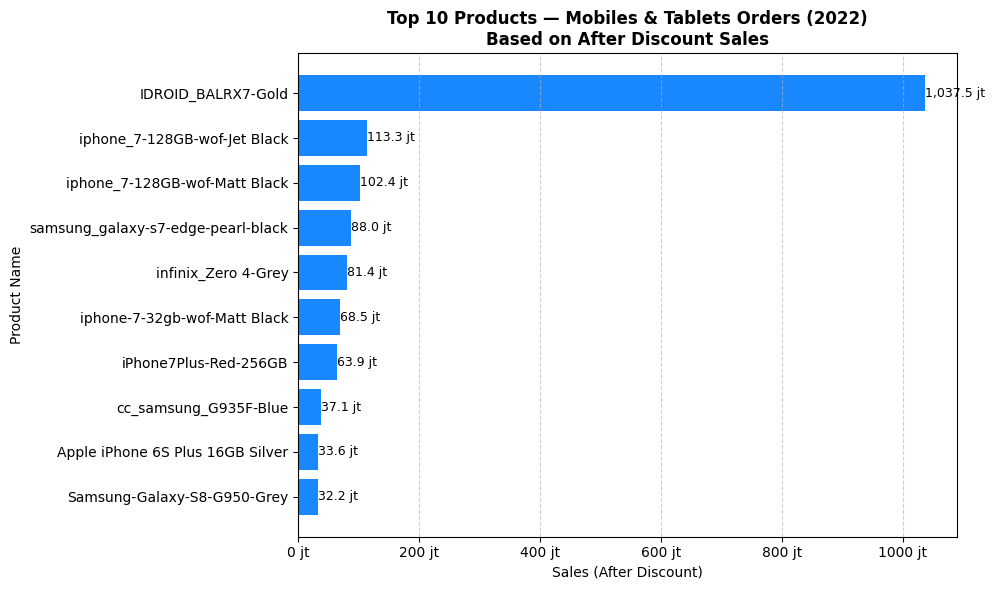

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

top10 = report.nlargest(10, 'after_discount')

def label_million(x, pos):
    return f"{int(x/1e6)} jt"

plt.figure(figsize=(10,6))
bars = plt.barh(top10['sku_name'], top10['after_discount'],
                color="#007bff", alpha=0.9)

plt.gca().invert_yaxis() 
plt.title("Top 10 Products — Mobiles & Tablets Orders (2022)\nBased on After Discount Sales", fontsize=12, weight='bold')
plt.xlabel("Sales (After Discount)")
plt.ylabel("Product Name")

plt.gca().xaxis.set_major_formatter(FuncFormatter(label_million))

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width()/1e6:,.1f} jt",
             va='center', ha='left', fontsize=9)

plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


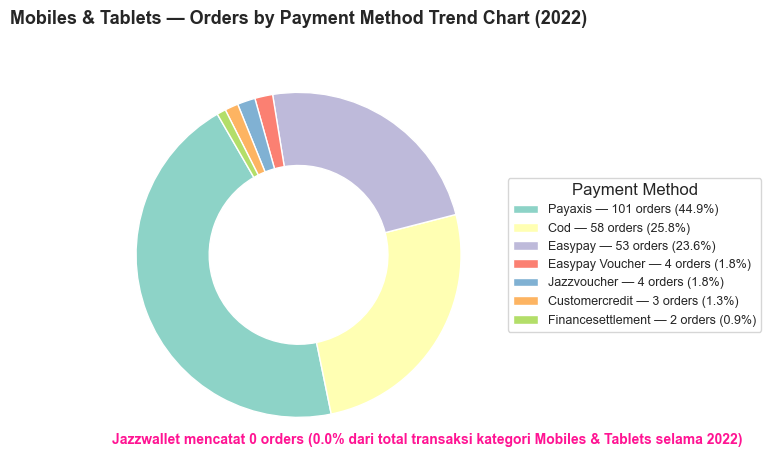

In [ ]:
orders_by_payment = (
    df_mt.groupby('payment_norm', dropna=False)[id_col]
         .nunique()
         .sort_values(ascending=False)
)
total_orders = orders_by_payment.sum()

if 'jazzwallet' in orders_by_payment.index:
    jazz_orders = int(orders_by_payment['jazzwallet'])
    jazz_pct = (jazz_orders / total_orders) * 100
else:
    jazz_orders = 0
    jazz_pct = 0

fig, ax = plt.subplots(figsize=(7,7))
colors = plt.cm.Set3.colors

wedges, texts = ax.pie(
    orders_by_payment,
    startangle=120,
    colors=colors,
    wedgeprops={'width': 0.45, 'edgecolor': 'white'}  # buat efek donut
)

ax.legend(
    wedges,
    [f"{label.title()} — {value:,} orders ({value/total_orders*100:.1f}%)"
     for label, value in zip(orders_by_payment.index, orders_by_payment.values)],
    title="Payment Method",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=9
)

plt.title("Mobiles & Tablets — Orders by Payment Method Trend Chart (2022)",
          fontsize=13, weight='bold', pad=20)

plt.figtext(
    0.5, 0.2,  
    f"Jazzwallet mencatat {jazz_orders:,} orders "
    f"({jazz_pct:.1f}% dari total transaksi kategori Mobiles & Tablets selama 2022)",
    ha="center", fontsize=10, color="#ff1493", weight='bold'
)

plt.tight_layout()
plt.show()
